# Mini Project 2 - Part 1

#### Andrew Geday - 260834063
#### Wassim Wazzi - 260825559
#### Cesar Arnouk - 260847683

In [59]:
import numpy as np
import random
import pandas as pd
from itertools import permutations
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Logistic Regression class along with helper functions

Text(0.5, 1.0, 'Logistic function')

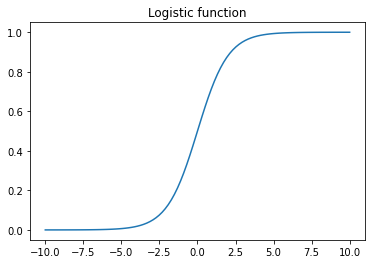

In [60]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function
z = np.linspace(-10,10,100)
plt.plot(z, logistic(z))
plt.title('Logistic function')

In [61]:
def cost_fn(x, y, w):
    N, D = x.shape                                                       
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
    return J

In [62]:
def gradient(self, x, y):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))    # predictions  size N
    grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
    return grad                         # size D

In [63]:
def get_accuracy(yh,y):
    yh = [0 if yh_i<0.5 else 1 for yh_i in yh]
    return sum(yh==y)/len(yh)

In [64]:
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        self.g = 0
        self.iterations = 0
        self.loss = 0
        self.norms = []
        self.train_acc = []
        self.val_acc = []
        
    def fit(self, x, y, x_val=None, y_val=None, get_prediction=False, beta=0, step=1000,formula=1):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        delta_w = np.zeros(D)
        g = np.inf 
        t = 0
            
        # the code snippet below is for gradient descent
        # with_norm set to True returns a list of the norms recorded at each iteration
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g=self.gradient(x,y)
            if formula ==2: # imporved formula
                delta_w = -self.learning_rate*g + beta*delta_w
                self.w = self.w + delta_w
            else: # formula from class
                delta_w = beta*delta_w + (1-beta)*g
                self.w = self.w - self.learning_rate * delta_w
            self.norms.append(np.linalg.norm(g))
            if x_val is not None and y_val is not None and get_prediction and (t%step==0):
                yh_train = self.predict(x, a_b=False)
                self.train_acc.append(get_accuracy(yh_train, y))
                yh_val = self.predict(x_val)
                self.val_acc.append(get_accuracy(yh_val, y_val))
            t+=1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')

        self.g = g
        self.iterations = t
        self.loss = cost_fn(x,y,self.w)
        
        return self
    
    def fit_mini_batch_stochastic(self, x, y, batch_size, x_val=None, y_val=None, step = 1000, get_prediction=False, beta = 0,formula=1):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        delta_w = np.zeros(D)
        g = np.inf 
        t = 0
        #num_of_epochs = int(self.max_iters/N)
        cur_epoch=0
        
        random.seed(1)
        index_list = np.random.permutation(N)
        batches = np.array_split(index_list, int(N/batch_size))
        while np.linalg.norm(g) > self.epsilon and cur_epoch < self.max_iters:
            for batch in batches:
                x_tmp = np.array([x[i] for i in batch])
                y_tmp = np.array([y[i] for i in batch])
                g=self.gradient(x_tmp,y_tmp)
                if formula ==2: # imporved formula
                    delta_w = -self.learning_rate*g + beta*delta_w
                    self.w = self.w + delta_w
                else: # formula from class
                    delta_w = beta*delta_w + (1-beta)*g
                    self.w = self.w - self.learning_rate * delta_w
                self.norms.append(np.linalg.norm(g))
                t+=1
            if x_val is not None and y_val is not None and get_prediction and(cur_epoch%step==0):
                yh_train = self.predict(x, a_b=False)
                self.train_acc.append(get_accuracy(yh_train, y))
                yh_val = self.predict(x_val)
                self.val_acc.append(get_accuracy(yh_val, y_val))
            cur_epoch +=1

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        
        self.g = g
        self.iterations = t

        return self

    def predict(self, x, a_b=True):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias and a_b:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

LogisticRegression.gradient = gradient             #initialize the gradient method of the LogisticRegression class with gradient function

### 1.1 - Finding adequate configuration for our Logistic Regression model

First of all, we started by finding out a good learning rate by trial and error. The way we did it was by out different values of 'learning_rate' in our LogisticRegression instance, while keeping the maxim number of iterations default (1e5) for time constraints. We plot the norm of our gradient with respect to the number of iterations for different values of 'learning_rate' in order to check for which values gradient descent works correctly:

In [65]:
#get training data
x = pd.read_csv("data_A2/diabetes/diabetes_train.csv", sep=",") # training data
y = x.loc[:, 'Outcome'].to_numpy() # array to label string
x = x.iloc[:, 0:-1] # drop label in dataframe
x = np.array(x)
y=np.array(y)

#get validation data
x_val = pd.read_csv("data_A2/diabetes/diabetes_val.csv", sep=",") # training data
y_val = x_val.loc[:, 'Outcome'].to_numpy() # array to label string
x_val = x_val.iloc[:, 0:-1] # drop label in dataframe
x_val = np.array(x_val)
y_val = np.array(y_val)

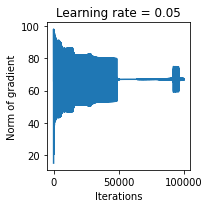

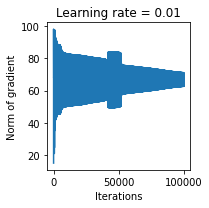

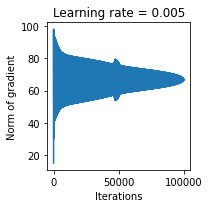

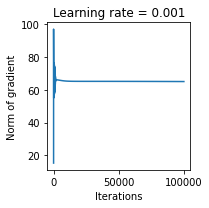

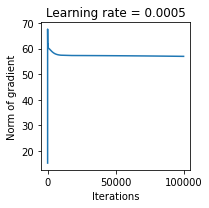

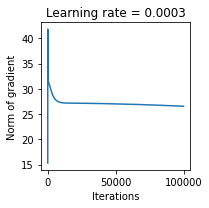

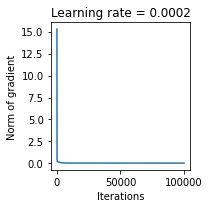

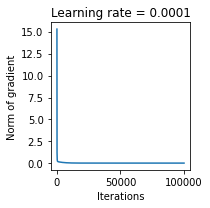

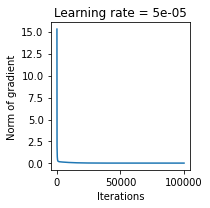

In [66]:
iters = [i for i in range(int(1e5))]
LR_results = pd.DataFrame(columns=["validation accuracy", "training accuracy", "learning rate", "max iters","gradient norm"])
theta_values = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0003, 0.0002, 0.0001, 0.00005]

for i, theta in enumerate(theta_values):
    model = LogisticRegression(learning_rate=theta, max_iters=1e5)
    model.fit(x,y)
    yh = model.predict(x)
    norms = model.norms
    yh_val = model.predict(x_val)
    val_acc = get_accuracy(yh_val, y_val)
    training_acc = get_accuracy(yh, y)
    LR_results.loc[i] = [val_acc, training_acc, theta, int(1e5), np.linalg.norm(model.g)]
    
    # let's plot
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot()
    ax.plot(iters, norms)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Norm of gradient')
    ax.set_title('Learning rate = ' + str(theta))
    plt.tight_layout()

In [67]:
LR_results.sort_values("validation accuracy", ascending=False)

,validation accuracy,training accuracy,learning rate,max iters,gradient norm
6,0.68,0.718333,0.00020,100000.0,0.032481
7,0.68,0.708333,0.00010,100000.0,0.034308
8,0.67,0.701667,0.00005,100000.0,0.035262
5,0.63,0.665000,0.00030,100000.0,26.548212
0,0.52,0.550000,0.05000,100000.0,66.586049
2,0.52,0.551667,0.00500,100000.0,66.765569
4,0.52,0.573333,0.00050,100000.0,56.951204
1,0.50,0.538333,0.01000,100000.0,66.311529
3,0.50,0.551667,0.00100,100000.0,65.000156


As seen from the graphs, only the gradient of models with learning rate lower than 0.0003 tends converge around 0, which indicates a proper gradient descent. We can also see that for a value of 0.0002, we get the best training and validation accuracies, so we will use this value for our learning rate for the rest of the project.
<br>
Let's study the convergence of our model for a learning rate of 0.0002. Let's try to visualize at which point the accuracy of our model starts stabilizing at high values.
<br>
We evaluate the accuracy of our model for training data as well as validation data at different maximum number of iterations. 
<br>
We start by the training data:

In [68]:
lr_model = LogisticRegression(learning_rate=0.0002, max_iters=1e5)
lr_model.fit(x,y,x_val,y_val,get_prediction=True, step=10)
train_accuracies = lr_model.train_acc
val_accuracies = lr_model.val_acc

Now that we have the accuracies for both training and validation data, we plot them and try to visualize a point of convergence:

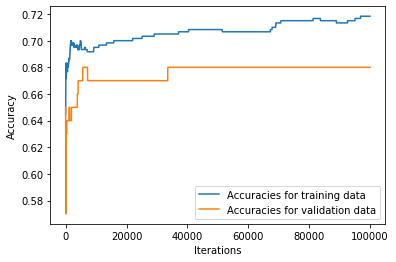

In [69]:
acc_iters = [i for i in range(0,int(1e5),10)]
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.plot(acc_iters, train_accuracies, label="Accuracies for training data")
plt.plot(acc_iters, val_accuracies, label="Accuracies for validation data")
plt.legend()

We can obviously see from the above graph that accuracy for validation data seems to fully stabilize after ~36000 iterations while training accuracy keeps increasing. We deduct that from this point on, the model would be overfitting the training data, which explains the increasing gap in the accuracies of the training and validation data. An intuitive remark is that we should expect the validation accuracy to drop beyond this point, at higher values of 'max_iters', since the model would be continuously overfitting the training data.
<br>
For simplicity, let's choose 40000 as a good parameter for 'max_iters'.

**In conclusion, a good configuration for our gradient descent would be by choosing a learning rate of 0.0002 and a maximum number of iterations of 40000.**

## 1.2 - Adding stochastic mini-batch to our model

We added a fit_mini_batch_stochastic to the LogisticRegression class.
We will use the best parametres found to run stochastic mini batch gradient descent

now running batch size =  8
now running batch size =  16
now running batch size =  32
now running batch size =  64
now running batch size =  128
now running batch size =  256
now running batch size =  600


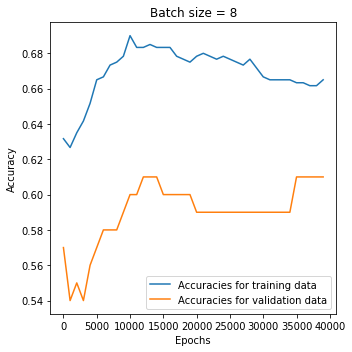

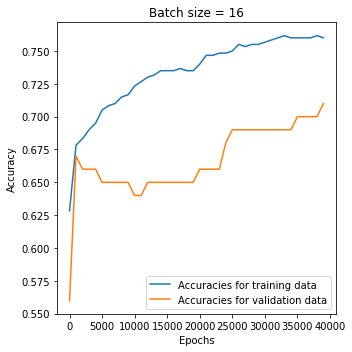

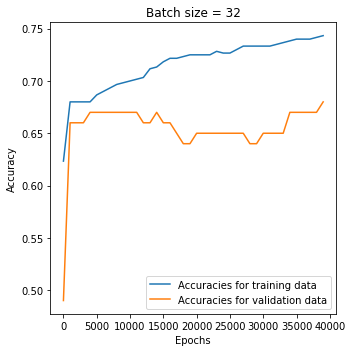

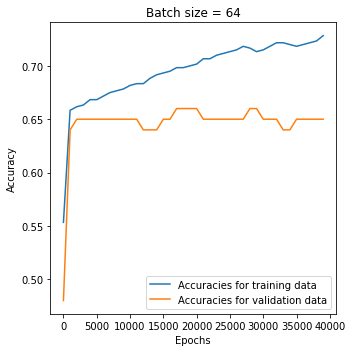

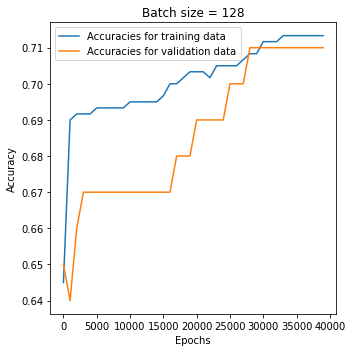

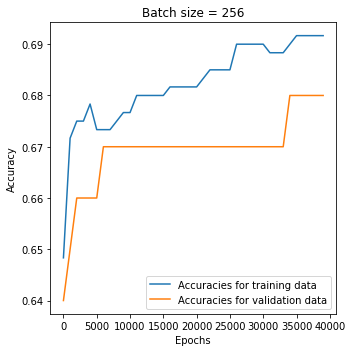

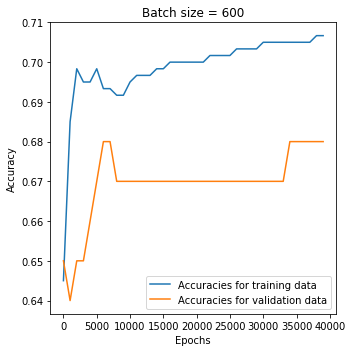

In [70]:
acc_iters = [i for i in range(int(1e4))]
batch_sizes = [8,16,32,64,128,256,x.shape[0]]
column_names = ["validation_accuracy","training_accuracy","gradient_norm", "iterations","batch_size"]
mini_batch_results = pd.DataFrame(columns=column_names)
step = 1000
  
for i, batch_size in enumerate(batch_sizes):
    print("now running batch size = ", str(batch_size))
    mb_model = LogisticRegression(learning_rate=0.0002, max_iters=40000)
    mb_model.fit_mini_batch_stochastic(x,y,batch_size,x_val,y_val,get_prediction=True, step=step)
    train_accuracies = mb_model.train_acc
    val_accuracies = mb_model.val_acc
    g_norm = np.linalg.norm(mb_model.g)
    iterations = mb_model.iterations
    mini_batch_results.loc[i] = [val_accuracies[-1],train_accuracies[-1], g_norm, iterations, batch_size]
    
    acc_iters = [i for i in range(0,step*len(val_accuracies),step)]
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()
    ax.plot(acc_iters, train_accuracies, label="Accuracies for training data")
    ax.plot(acc_iters, val_accuracies, label="Accuracies for validation data")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.set_title('Batch size = ' + str(batch_size))
    plt.tight_layout()

In [71]:
mini_batch_results.sort_values("validation_accuracy", ascending=False)

,validation_accuracy,training_accuracy,gradient_norm,iterations,batch_size
1,0.71,0.760000,29.622341,1480000.0,16.0
4,0.71,0.713333,3.153934,160000.0,128.0
2,0.68,0.743333,5.485405,720000.0,32.0
5,0.68,0.691667,13.225942,80000.0,256.0
6,0.68,0.706667,0.034686,40000.0,600.0
3,0.65,0.728333,18.086180,360000.0,64.0
0,0.61,0.665000,22.917078,3000000.0,8.0


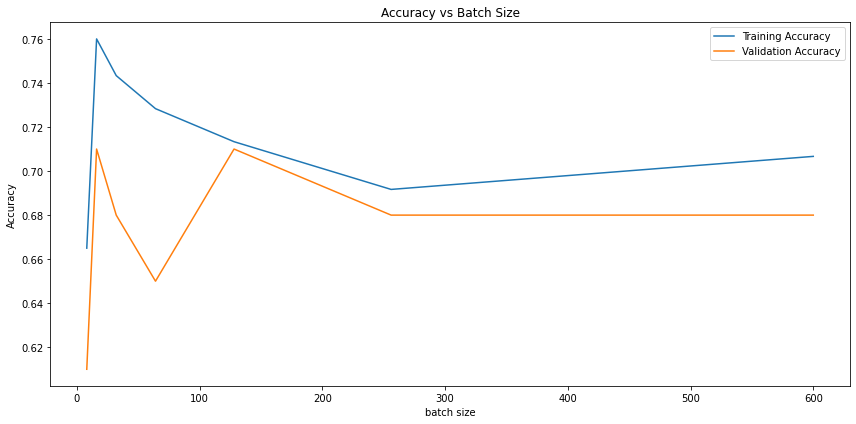

In [72]:
# accuracy for each batch_size
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
ax.plot(mini_batch_results.loc[:,'batch_size'], mini_batch_results.loc[:,'training_accuracy'], label="Training Accuracy")
ax.plot(mini_batch_results.loc[:,'batch_size'], mini_batch_results.loc[:,'validation_accuracy'], label="Validation Accuracy")
ax.legend()
ax.set_xlabel('batch size')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs Batch Size')
plt.tight_layout()

### 1.3 - Momentum

Now, we want to add momentum to our Logistic Regression model. We try out 2 different formulas for updating our w vector using the momentum: 
<br>The first one was the one seen in class, and the second one is a pretty popular formula used when implementing momentum:

#### 1.3.1 - Momentum using formula seen in class:

now running beta =  0
now running beta =  0.5
now running beta =  0.9
now running beta =  0.925
now running beta =  0.95
now running beta =  0.975
now running beta =  0.99
now running beta =  0.999
now running beta =  0.9999


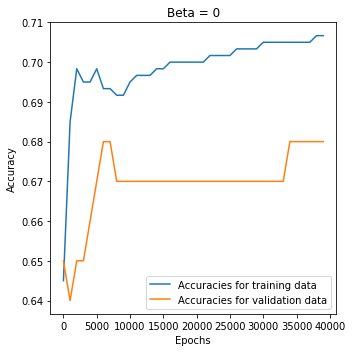

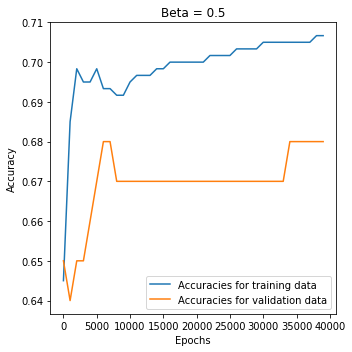

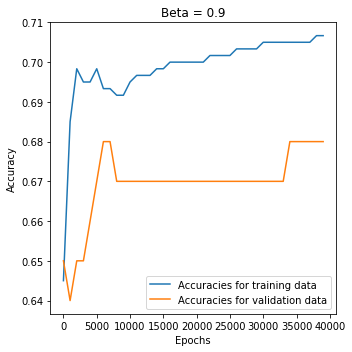

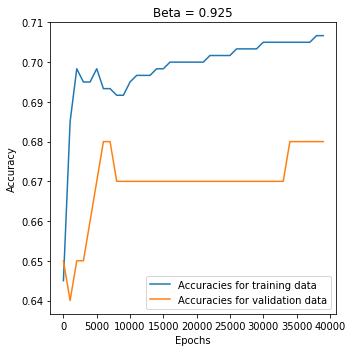

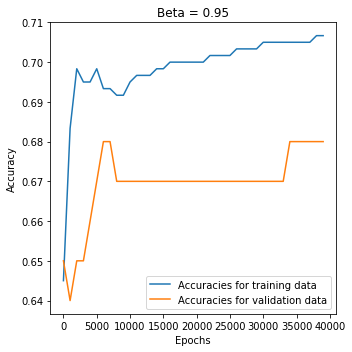

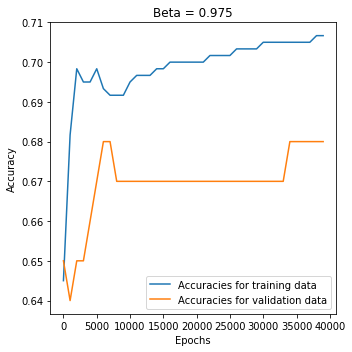

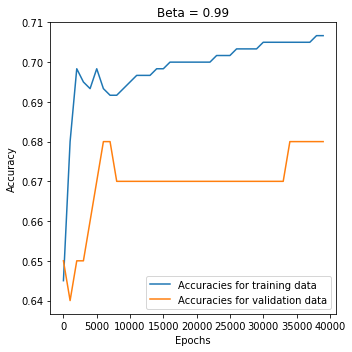

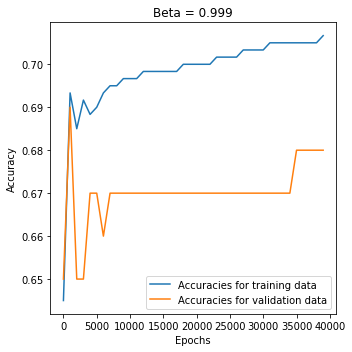

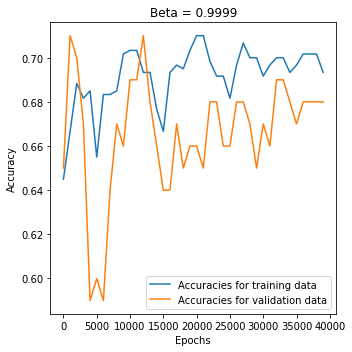

In [73]:
beta_values = [0, 0.5, 0.9, 0.925, 0.95, 0.975, 0.99, 0.999, 0.9999]
column_names = ["validation_accuracy","training_accuracy","gradient_norm", "iterations","batch_size","beta"]
momentum_results = pd.DataFrame(columns=column_names)
norms = []
  
for i in range(0, len(beta_values)):
    beta = beta_values[i]
    print("now running beta = ", str(beta))
    mom_model = LogisticRegression(learning_rate=0.0002, max_iters=40000)
    mom_model.fit(x,y,x_val,y_val,get_prediction=True, beta=beta)
    train_accuracies = mom_model.train_acc
    val_accuracies = mom_model.val_acc
    g_norm = np.linalg.norm(mom_model.g)
    iterations = mom_model.iterations
    norms = mom_model.norms
    momentum_results.loc[i] = [val_accuracies[-1],train_accuracies[-1], g_norm, iterations,600, beta]
    
    acc_iters = [i for i in range(0,1000*len(val_accuracies),1000)]
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()
    ax.plot(acc_iters, train_accuracies, label="Accuracies for training data")
    ax.plot(acc_iters, val_accuracies, label="Accuracies for validation data")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.set_title('Beta = ' + str(beta))
    plt.tight_layout()

In [74]:
momentum_results.sort_values("validation_accuracy", ascending=False)

,validation_accuracy,training_accuracy,gradient_norm,iterations,batch_size,beta
0,0.68,0.706667,0.034686,40000.0,600.0,0.0000
1,0.68,0.706667,0.034686,40000.0,600.0,0.5000
2,0.68,0.706667,0.034687,40000.0,600.0,0.9000
3,0.68,0.706667,0.034687,40000.0,600.0,0.9250
4,0.68,0.706667,0.034687,40000.0,600.0,0.9500
5,0.68,0.706667,0.034688,40000.0,600.0,0.9750
6,0.68,0.706667,0.034690,40000.0,600.0,0.9900
7,0.68,0.706667,0.034723,40000.0,600.0,0.9990
8,0.68,0.693333,1.262373,40000.0,600.0,0.9999


#### 1.3.2 - Momentum using popular formula:

now running beta =  0
now running beta =  0.5
now running beta =  0.9
now running beta =  0.925
now running beta =  0.95
now running beta =  0.975
now running beta =  0.99
now running beta =  0.999
now running beta =  0.999


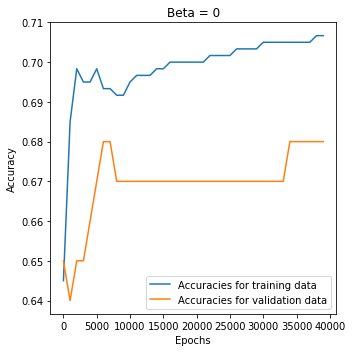

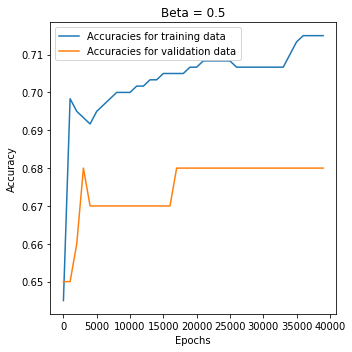

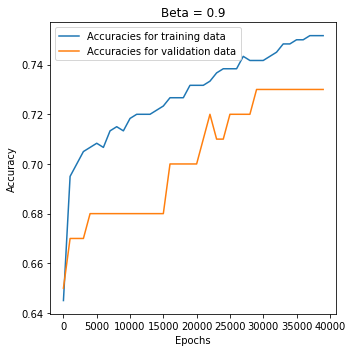

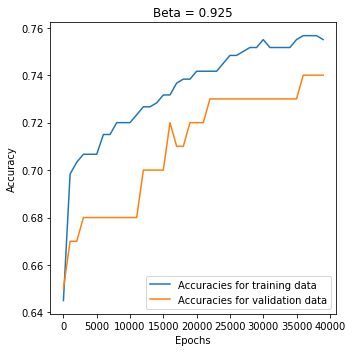

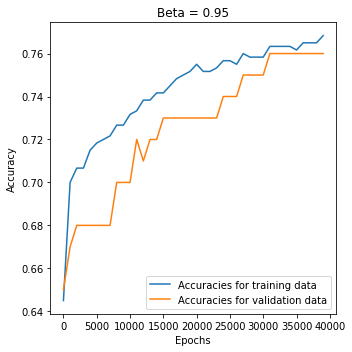

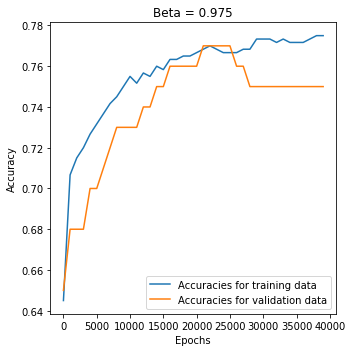

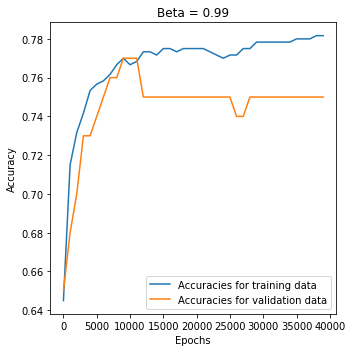

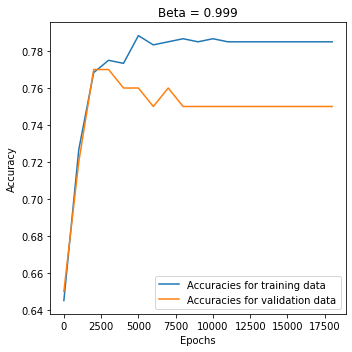

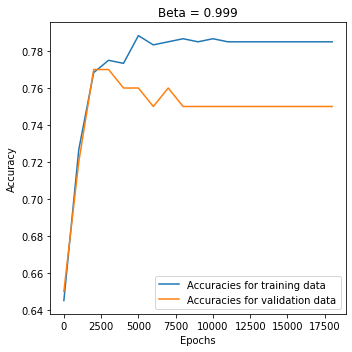

In [75]:
beta_values = [0, 0.5, 0.9, 0.925, 0.95, 0.975, 0.99, 0.999, 0.999]
column_names = ["validation_accuracy","training_accuracy","gradient_norm", "iterations","batch_size","beta"]
momentum_results2 = pd.DataFrame(columns=column_names)
norms = []
  
for i, beta in enumerate(beta_values):
    print("now running beta = ", str(beta))
    mom_model = LogisticRegression(learning_rate=0.0002, max_iters=40000)
    mom_model.fit(x,y,x_val,y_val,get_prediction=True, beta = beta, formula=2)
    train_accuracies = mom_model.train_acc
    val_accuracies = mom_model.val_acc
    g_norm = np.linalg.norm(mom_model.g)
    iterations = mom_model.iterations
    norms = mom_model.norms
    momentum_results2.loc[i] = [val_accuracies[-1],train_accuracies[-1], g_norm, iterations,600, beta]
    
    acc_iters = [i for i in range(0,1000*len(val_accuracies),1000)]
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()
    ax.plot(acc_iters, train_accuracies, label="Accuracies for training data")
    ax.plot(acc_iters, val_accuracies, label="Accuracies for validation data")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Beta = ' + str(beta))
    ax.legend()
    plt.tight_layout()

In [76]:
momentum_results2.sort_values("validation_accuracy", ascending=False)

,validation_accuracy,training_accuracy,gradient_norm,iterations,batch_size,beta
4,0.76,0.768333,0.016002,40000.0,600.0,0.950
5,0.75,0.775000,0.008417,40000.0,600.0,0.975
6,0.75,0.781667,0.001962,40000.0,600.0,0.990
7,0.75,0.785000,0.000063,18364.0,600.0,0.999
8,0.75,0.785000,0.000063,18364.0,600.0,0.999
3,0.74,0.755000,0.020606,40000.0,600.0,0.925
2,0.73,0.751667,0.023583,40000.0,600.0,0.900
0,0.68,0.706667,0.034686,40000.0,600.0,0.000
1,0.68,0.715000,0.033199,40000.0,600.0,0.500


### 1.4
Now we will run momentum gradient descent with the smallest and largest batch sizes.
<br>
Let's see what results we get compared to the fully batched baseline

now running beta = 0 batch = 8
now running beta = 0 batch = 256
now running beta = 0.5 batch = 8
now running beta = 0.5 batch = 256
now running beta = 0.9 batch = 8
now running beta = 0.9 batch = 256
now running beta = 0.925 batch = 8
now running beta = 0.925 batch = 256
now running beta = 0.95 batch = 8
now running beta = 0.95 batch = 256
now running beta = 0.975 batch = 8
now running beta = 0.975 batch = 256
now running beta = 0.99 batch = 8
now running beta = 0.99 batch = 256


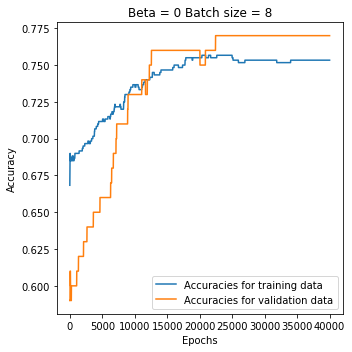

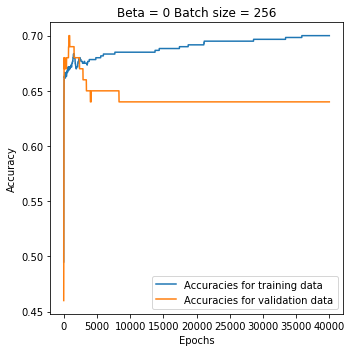

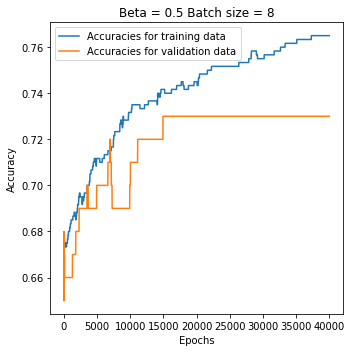

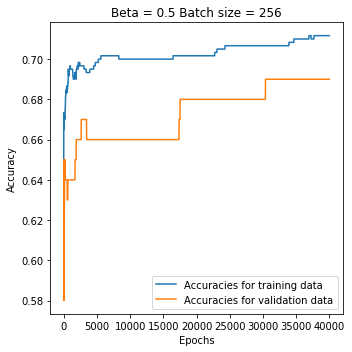

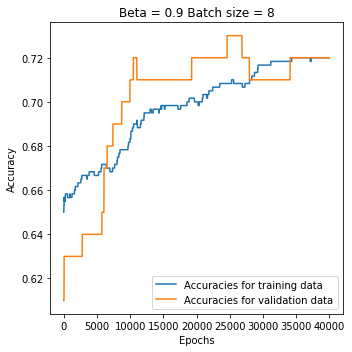

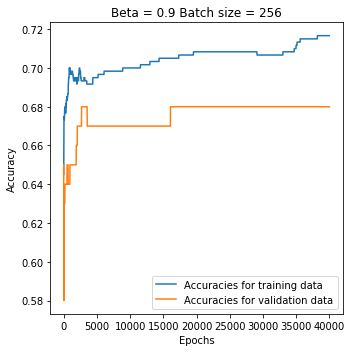

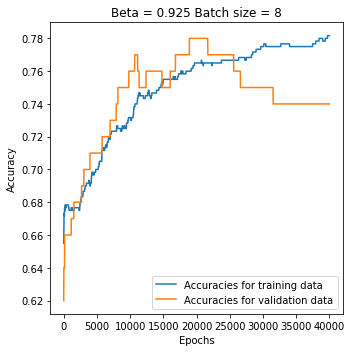

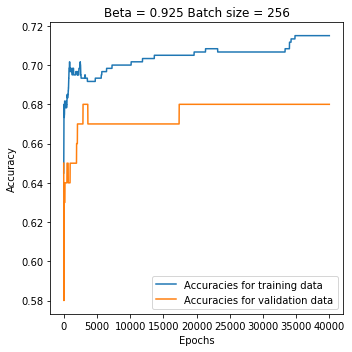

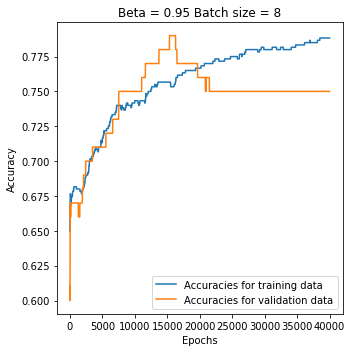

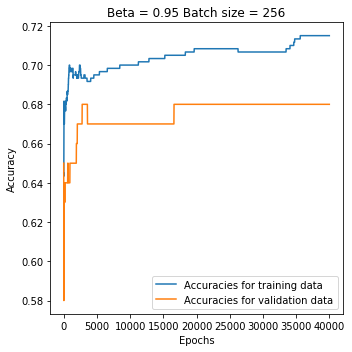

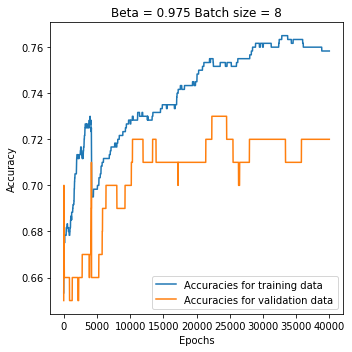

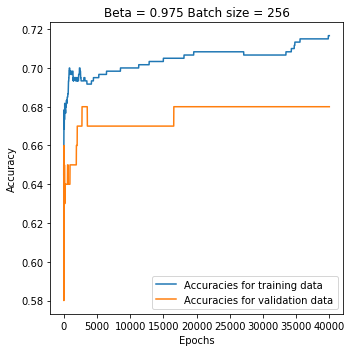

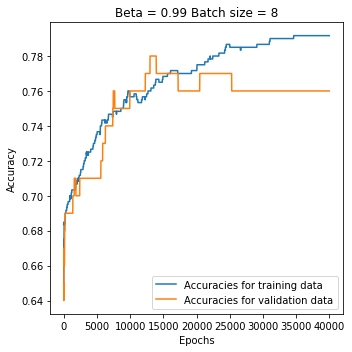

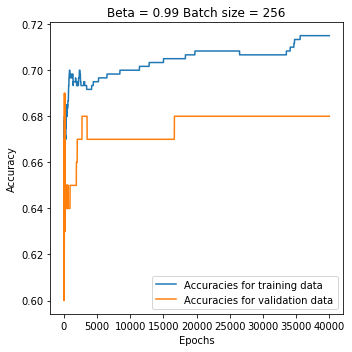

In [77]:
beta_values = [0, 0.5, 0.9, 0.925, 0.95, 0.975, 0.99]
batch_sizes = [8,256]
column_names = ["validation_accuracy","training_accuracy","gradient_norm","batch_size","beta"]
momentum_results = pd.DataFrame(columns=column_names)
norms = []
n=0

for beta in beta_values:
    for batch_size in batch_sizes:
        print("now running beta = " + str(beta) + " batch = " + str(batch_size))
        mom_model = LogisticRegression(learning_rate=0.0002, max_iters=40000)
        mom_model.fit_mini_batch_stochastic(x,y,batch_size,x_val,y_val,get_prediction=True, beta = beta,step=10)
        train_accuracies = mom_model.train_acc
        val_accuracies = mom_model.val_acc
        g_norm = np.linalg.norm(mom_model.g)
        norms = mom_model.norms
        momentum_results.loc[n] = [val_accuracies[-1],train_accuracies[-1], g_norm, batch_size, beta]
        n+=1
        
        acc_iters = [i for i in range(0,10*len(val_accuracies), 10)]
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot()
        ax.plot(acc_iters, train_accuracies, label="Accuracies for training data")
        ax.plot(acc_iters, val_accuracies, label="Accuracies for validation data")
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        ax.legend()
        ax.set_title('Beta = ' + str(beta)+ " Batch size = " + str(batch_size))
        plt.tight_layout()

In [78]:
momentum_results.sort_values("validation_accuracy", ascending=False)

,validation_accuracy,training_accuracy,gradient_norm,batch_size,beta
0,0.77,0.753333,33.016715,8.0,0.000
12,0.76,0.791667,31.852981,8.0,0.990
8,0.75,0.788333,11.603790,8.0,0.950
6,0.74,0.781667,8.325052,8.0,0.925
2,0.73,0.765000,63.890829,8.0,0.500
4,0.72,0.720000,85.247104,8.0,0.900
10,0.72,0.758333,15.245741,8.0,0.975
3,0.69,0.711667,7.829084,256.0,0.500
5,0.68,0.716667,4.082665,256.0,0.900
7,0.68,0.715000,4.307834,256.0,0.925
